# Building Damage and Population Exposure from Floods

Click [![Flood Damage and Population Exposure](https://img.shields.io/badge/FLOOD-repository-blue)](https://github.com/CLIMAAX/FLOODS) to go to this workflow's GitHub repository.

## Methodology
This workflow will map water depths at different flood return periods by using flood data, as well as population distribution using a global dataset.

The code can be customised to use local data.

### Limitations
The flooding maps do not take into consideration possible water defence structures that may in reality limit the impact of the hazard. Moreover, the resolution of 3 arc-seconds for both the flooding maps and population maps may be unsuitable for particularly complex regions. Additionally, the flood dataset used only takes into account large basins.
If possible, it is suggested to use local data which may lead to a better representation of the ground truth.


### Import Modules

:::{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

These modules are needed to process the flood depth raster data and building shapefiles as well as plot the results.

- [os](https://docs.python.org/3/library/os.html): For interacting with the operating system, allowing the creation of directories and file manipulation.
- [sys](https://docs.python.org/3/library/sys.html): Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- [numpy](https://numpy.org/): A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [pandas](https://pandas.pydata.org/): A data manipulation and analysis library, essential for working with structured data in tabular form.
- [geopandas](https://geopandas.org): Extends the datatypes used by pandas to allow spatial operations on geometric types.
- [rasterio](https://rasterio.readthedocs.io/en/stable/): For reading and writing geospatial raster data, providing functionalities to explore and manipulate raster datasets.
- [rasterstats](https://pythonhosted.org/rasterstats): For summarizing geospatial raster datasets based on vector geometries.
- [shapely](https://pypi.org/project/shapely/): For manipulation and analysis of planar geometric objects.
- [osgeo](https://www.osgeo.org/): For translating raster and vector geospatial data formats.
- [osmnx](https://osmnx.readthedocs.io/) To easily download, model, analyze, and visualize street networks and other geospatial features from OpenStreetMap.
- [pyproj](https://pyproj4.github.io/pyproj/dev/index.html): Interface for PROJ (cartographic projections and coordinate transformations library).
- [matplotlib](https://matplotlib.org/): Used for creating static, animated, and interactive visualizations.
- [contextily](https://contextily.readthedocs.io/en/latest/): For adding basemaps to plots, enhancing geospatial visualizations.
- [urllib.request](https://docs.python.org/3/library/urllib.request.html): Defines functions and classes which help in opening URLs (mostly HTTP) in a complex world — basic and digest authentication, redirections, cookies and more.
- [zipfile](https://docs.python.org/3/library/zipfile.html): Provides tools to create, read, write, append, and list a ZIP file.
- [sockect](https://docs.python.org/3/library/socket.html): pPovides access to the BSD socket interface.

:::

In [2]:
# Install requirments: (Note, by default these are commented out. Temporarly remove the quotation marks to install them if the code doesn't work at the start)
"""%pip install rasterio
%pip install rasterstats
%pip install osmnx
%pip install contextily"""

# Import modules: 
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
from rasterio.warp import reproject, calculate_default_transform
from rasterio.mask import mask
from rasterio.transform import Affine
# from rasterio.crs import CRS
import rasterstats
from osgeo import gdal, osr, ogr
from shapely.geometry import box, Polygon, shape
import osmnx as ox
from pyproj import Transformer
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx
import urllib.request
import zipfile
from zipfile import ZipFile
import socket


## Definitions
In this section different important parameters can be set. Please read the descriptions when provided to ensure the appropriate changes are made. 
- Bounds of area of interest.  Positive values denote north and east, and negative values denote south and west.
- Code flags (e.g. choosing which maps get produced)
- Return periods
- Directory locations
- Colorbars for maps

In [3]:
## Location (in ESPG:4326) --------------------------------------
# Florence, Italy (Example 1)
Latitude1, Latitude2 = 43.76, 43.79
Longitude1, Longitude2 = 11.24, 11.30

# Žilina, Slovakia (Example 2)
Latitude1, Latitude2 = 49.2, 49.25
Longitude1, Longitude2 = 18.69, 18.78

"""#Larvik, Norway (Example 3, stitching example)
Latitude1, Longitude1 = 59.18456,9.89745
Latitude2, Longitude2 = 58.95307,10.11063"""

# Ordering coordinates
Latitude1, Latitude2 = min(Latitude1, Latitude2), max(Latitude1, Latitude2)
Longitude1, Longitude2 = min(Longitude1, Longitude2), max(Longitude1, Longitude2)

## Return Periods of Interest ------------------------------------
# Return period levels, if using original source pick from [10, 20, 30, 40, 50, 75, 100, 200, 500]
ReturnPeriods = [10, 50, 100, 500]  

## Population estimate/projection year ---------------------------
#Can choose any year with a 5 year interval between 1975 and 2030 (estimates until 2020, projections after 2020)
PopYear = 2025 

# Checking right date is chosen
if not (isinstance(PopYear, int) and 1975 <= PopYear <= 2030 and PopYear % 5 == 0):
    raise ValueError("The variable must be an integer, between 1975 and 2030, and a multiple of 5.")

## Water Depths for Exposed and Displaced Population---------------
# If depth is greater than this, the population is exposed
minDepthExposed = 0.1 
# If depth is greater than this, the population is displaced
minDepthDisplaced = 1.0 


## Figure Options ------------------------------------------
# Return period for the optional figures. If using original source pick from [10, 20, 50, 100, 200, 500]
ImageReturnPeriod = [10,500] #At least one input

for value in ImageReturnPeriod:
    if value not in ReturnPeriods:
        raise ValueError(f"Value {value} in ImageReturnPeriod is not present in ReturnPeriods, i.e. workflow is trying to create graphics from a return period not being analysed.\nEither remove it from ImageReturnPeriod, or add it into ReturnPeriod.")


## Figure Colour Scheme -------------------------------
# Water Depth Colorbar for Maps
cmap_h2o = LinearSegmentedColormap.from_list('gist_stern_inv',
                                             ['blue', 'red'], N=256)

# Population Colorbar for Maps
cmap_pop = LinearSegmentedColormap.from_list('gist_stern_inv',
                                             ['orange', 'red','fuchsia'], N=256)



## Data Management ----------------------------------
RP, tile_id_max = True,0 #Temporary initiation, will automatically change in workflow

# Directory of main folder (working directory)
dirWork = '.'
os.chdir(dirWork)

# Input Hazard Path
dirDepths = os.path.join(dirWork, 'data')
if not os.path.exists(dirDepths):
    os.makedirs(dirDepths)

# OSM Output Path
dirOSM = os.path.join(dirWork, 'OSM')
if not os.path.exists(dirOSM):
    os.makedirs(dirOSM)

# Results directory
dirResults = os.path.join(dirWork, 'DamageBuildings')
if not os.path.exists(dirResults):
    os.makedirs(dirResults)
dirResultsPop = os.path.join(dirWork, 'ExposePopulation')
if not os.path.exists(dirResultsPop):
    os.makedirs(dirResultsPop)



## Download Data
In this section, the data required to run the analysis is downloaded. 
- Download flood depth and population rasters to the data folder if the file doesn't exist.
- River flood extent and water depth are from the [Copernicus Land Monitoring Service](https://data.jrc.ec.europa.eu/dataset/1d128b6c-a4ee-4858-9e34-6210707f3c81) for different event return periods at a 100m grid spacing.
- Population densities are from the [European Commission's Joint Research Centre](https://data.jrc.ec.europa.eu/dataset/2ff68a52-5b5b-4a22-8f40-c41da8332cfe).

This section can be modified to use local data.

In [4]:
#This workflow is using European data. If personal data wants to be used
#Note: There is a known issue with Mollweide projections. Standard projection used is 'EPSG:4326'

timeout = 90    # Download time out in seconds
max_retries = 5  # Maximum number of download attempts
socket.setdefaulttimeout(timeout)

##Flood data download
urlData='https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-EFAS/flood_hazard/'

for RP in ReturnPeriods:
    print(f'Return Period={str(RP)}')
    rastDepths = os.path.join(dirDepths, f'Europe_RP{RP}_filled_depth.tif')
    if os.path.exists(rastDepths):
        print(f'Flood depth raster already exists (skipping download): {rastDepths}')
    else:
        rastTif = f'Europe_RP{RP}_filled_depth.tif'
        pathRastTif = os.path.join(dirDepths, rastTif)
        urlRastTif = os.path.join(urlData, rastTif)
        print(urlRastTif)
        for attempt in range(1, max_retries + 1):
            print(f'    Attempt: {attempt}')
            try:
                urllib.request.urlretrieve(urlRastTif, pathRastTif)
                break  # Break loop if download is successful
            except Exception as e:
                print('      Timeout.  Retry data download')
                if attempt == max_retries:
                    print('    Maximum number of timeouts reached.  Data download failed')
                    print(f'      Consider increasing timeout value {timeout} seconds')
                    print(f'      Consider increasing maximum number of download attempts {max_retries}')
                    raise Exception(f'Timeout time {timeout} seconds exceeded {max_retries}')
        print('  Unzipping downloaded file')


##Population data download ------------------------
def download_pop_rast(tile_id):#Downloading the raster files for Population
    print(f'Population tile id: {tile_id}')
    urlDataPop=f'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss/V1-0/tiles/'
    rastPopulation= os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id}.tif')
    if os.path.exists(rastPopulation):
        print(f'Population raster already exists (skipping download)')
    else:
        rastZip = f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id}.zip'
        pathRastZip = os.path.join(dirDepths, rastZip)
        urlRastZip = os.path.join(urlDataPop, rastZip)
        print(urlRastZip)
        for attempt in range(1, max_retries + 1):
            print(f'    Attempt: {attempt}')
            try:
                urllib.request.urlretrieve(urlRastZip, pathRastZip)
                break  # Break loop if download is successful
            except Exception as e:
                print('      Timeout.  Retry data download')
                if attempt == max_retries:
                    print('    Maximum number of timeouts reached.  Data download failed')
                    print(f'      Consider increasing timeout value {timeout} seconds')
                    print(f'      Consider increasing maximum number of download attempts {max_retries}')
                    raise Exception(f'Timeout time {timeout} seconds exceeded {max_retries}')
        print('  Unzipping downloaded file')
        with ZipFile(pathRastZip, 'r') as zip_ref:
            zip_ref.extract(f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id}.tif',dirDepths)

def stitch_on_right(file1, file2, output_file):
    if os.path.exists(output_file):
        print(f'Stitched population raster already exists (skipping download)')
    else:
        with rasterio.open(file1) as src1, rasterio.open(file2) as src2:
            # Get metadata and transform of the first raster
            meta = src1.meta.copy()

            # Calculate new dimensions for the stitched raster
            new_width = src1.width + src2.width
            new_height = max(src1.height, src2.height)

            # Update metadata with new dimensions
            meta.update(width=new_width, height=new_height)

            # Create output raster
            with rasterio.open(output_file, 'w', **meta) as dst:
                # Write the first raster to the output raster
                dst.write(src1.read(), window=rasterio.windows.Window(col_off=0, row_off=0, width=src1.width, height=src1.height))

                # Write the second raster to the output raster
                for i in range(1, src2.count + 1):
                    dst.write(src2.read(i), i, window=rasterio.windows.Window(col_off=src1.width, row_off=0, width=src2.width, height=src2.height))

def stitch_on_top(file1, file2, output_file):#Stitching two rasters vertically
    if os.path.exists(output_file):
        print(f'Stitched population raster already exists (skipping download)')
    else:
        with rasterio.open(file1) as src1, rasterio.open(file2) as src2:
            # Get metadata and transform of the first raster
            meta = src2.meta.copy()

            # Calculate new dimensions for the stitched raster
            new_width = max(src1.width, src2.width)
            new_height = src1.height + src2.height

            # Update metadata with new dimensions
            meta.update(width=new_width, height=new_height)

            # Create output raster
            with rasterio.open(output_file, 'w', **meta) as dst:
                # Write the second raster to the output raster
                dst.write(src2.read(), window=rasterio.windows.Window(col_off=0, row_off=0, width=src2.width, height=src2.height))

                # Write the first raster to the output raster
                for i in range(1, src1.count + 1):
                    dst.write(src1.read(i), i, window=rasterio.windows.Window(col_off=0, row_off=src1.height, width=src1.width, height=src1.height))

def stitch_all(file1, file2, file3, file4, output_file):#Stitching four rasters
    if os.path.exists(output_file):
        print(f'Stitched population raster already exists (skipping download)')
    else:
        with rasterio.open(file1) as src1, rasterio.open(file2) as src2, rasterio.open(file3) as src3, rasterio.open(file4) as src4:
            # Get metadata and transform of the first raster
            meta = src3.meta.copy()

            # Calculate new dimensions for the stitched raster
            new_width = src3.width + src4.width
            new_height = src1.height + src3.height

            # Update metadata with new dimensions
            meta.update(width=new_width, height=new_height)

            # Create output raster
            with rasterio.open(output_file, 'w', **meta) as dst:
                # Write the first raster to the output raster
                dst.write(src3.read(), window=rasterio.windows.Window(col_off=0, row_off=0, width=src3.width, height=src3.height))

                # Write the second raster to the output raster
                for i in range(1, src4.count + 1):
                    dst.write(src4.read(i), i, window=rasterio.windows.Window(col_off=src3.width, row_off=0, width=src4.width, height=src4.height))

                # Write the third raster to the output raster
                for i in range(1, src1.count + 1):
                    dst.write(src1.read(i), i, window=rasterio.windows.Window(col_off=0, row_off=src3.height, width=src1.width, height=src1.height))
                
                # Write the fourth raster to the output raster
                for i in range(1, src2.count + 1):
                    dst.write(src2.read(i), i, window=rasterio.windows.Window(col_off=src1.width, row_off=src3.height, width=src2.width, height=src2.height))


urlDataPopScheme='https://ghsl.jrc.ec.europa.eu/download/'
shpPopScheme = os.path.join(dirDepths, f'WGS84_tile_schema.shp')
if os.path.exists(shpPopScheme):
    print(f'Population scheme shapefile already exists (skipping download)')
else:
    rastZip = f'GHSL_data_4326_shapefile.zip'
    pathRastZip = os.path.join(dirDepths, rastZip)
    urlRastZip = os.path.join(urlDataPopScheme, rastZip)
    print(urlRastZip)
    for attempt in range(1, max_retries + 1):
        print(f'    Attempt: {attempt}')
        try:
            urllib.request.urlretrieve(urlRastZip, pathRastZip)
            break  # Break loop if download is successful
        except Exception as e:
            print('      Timeout.  Retry data download')
            if attempt == max_retries:
                print('    Maximum number of timeouts reached.  Data download failed')
                print(f'      Consider increasing timeout value {timeout} seconds')
                print(f'      Consider increasing maximum number of download attempts {max_retries}')
                raise Exception(f'Timeout time {timeout} seconds exceeded {max_retries}')
    print('  Unzipping downloaded file')
    with ZipFile(pathRastZip, 'r') as zip_ref:
        zip_ref.extractall(dirDepths)

# Load the shapefile
gdf = gpd.read_file(shpPopScheme)

# Iterate through each polygon and check if the point is inside
tile_id_min, tile_id_max = None, None 
for index, row in gdf.iterrows():
    left, top, right, bottom = row['left'], row['top'], row['right'], row['bottom']
    # Check if the point is within the bounding box of the polygon
    if left <= Longitude1 <= right and bottom <= Latitude1 <= top:
        tile_id_min = row['tile_id']
    if left <= Longitude2 <= right and bottom <= Latitude2 <= top:
        tile_id_max = row['tile_id']
    if tile_id_min is not None and tile_id_max is not None:
        break

tileMax=tile_id_max.split('_')
Rmax, Cmax = tileMax[0][1:].split('R')[0], tileMax[1][1:].split('C')[0]
tileMin=tile_id_min.split('_')
Rmin, Cmin = tileMin[0][1:].split('R')[0], tileMin[1][1:].split('C')[0]


if tile_id_min == tile_id_max:
    download_pop_rast(tile_id_max)
    rastPopulation= os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_max}.tif')

elif Rmin == Rmax and Cmin < Cmax:  # Stitch on the right
    download_pop_rast(tile_id_max)
    download_pop_rast(tile_id_min)  
    file1 = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_min}.tif')
    file2 = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_max}.tif')
    rastPopulation = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_min}_to_{tile_id_max}.tif')
    stitch_on_right(file1, file2, rastPopulation)
    print(f'Stitched horizontally tiles {tile_id_min} and {tile_id_max}.')
elif Rmin > Rmax and Cmin == Cmax: # Stitch on the top
    download_pop_rast(tile_id_max)
    download_pop_rast(tile_id_min) 
    file1 = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_min}.tif')
    file2 = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_max}.tif')
    rastPopulation = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_min}_to_{tile_id_max}.tif')
    stitch_on_top(file1, file2, rastPopulation)
    print(f'Stitched vertically tiles {tile_id_min} and {tile_id_max}.')
elif Rmin > Rmax and Cmin < Cmax:
    download_pop_rast(tile_id_max)
    download_pop_rast(tile_id_min)
    tile_id_tmp1=f'R{Rmin}_C{Cmax}'
    tile_id_tmp2=f'R{Rmax}_C{Cmin}'
    download_pop_rast(tile_id_tmp1)
    download_pop_rast(tile_id_tmp2)
    file1 = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_min}.tif')
    file2 = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_tmp1}.tif')
    file3 = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_tmp2}.tif')
    file4 = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_max}.tif')
    rastPopulation = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_min}_{tile_id_tmp1}_to_{tile_id_max}_{tile_id_tmp2}.tif')
    stitch_all(file1,file2,file3,file4,rastPopulation)
    print(f'Stitched together tiles {tile_id_min}, {tile_id_tmp1}, {tile_id_max}, {tile_id_tmp2}.')
    print(f'Filen location: {rastPopulation}')
else:
    raise ValueError(f"Location crosses population rasters {tile_id_min} and {tile_id_max}. Modify location or use personal data.)")


Return Period=10
Flood depth raster already exists (skipping download): .\data\Europe_RP10_filled_depth.tif
Return Period=50
Flood depth raster already exists (skipping download): .\data\Europe_RP50_filled_depth.tif
Return Period=100
Flood depth raster already exists (skipping download): .\data\Europe_RP100_filled_depth.tif
Return Period=500
Flood depth raster already exists (skipping download): .\data\Europe_RP500_filled_depth.tif
Population scheme shapefile already exists (skipping download)
Population tile id: R4_C20
Population raster already exists (skipping download)


## Bounding Box Computations
In this section the bounding box of the data is generated.
- Converts latitude and longitude values to the equivalent projection used by the water depth and population raster & writes bounding box to shapefile.
- Defines bounding box for OpenStreetMap data.

If the region of interest is not as desired, the latitude and longitude values can be changed in the "Definitions" section above.

Water Depth Raster Projection: EPSG:4326
Converted Coordinate Bounds:
  Longitudes: 18.69E --> 18.69 meters & 18.78E --> 18.78 meters
  Latitudes: 49.2N --> 49.2 meters & 49.25N --> 49.25 meters
Bounding Box Shapefile written to: .\OSM\bbox.shp
  49.2N to 49.25N
  18.69E to 18.78E


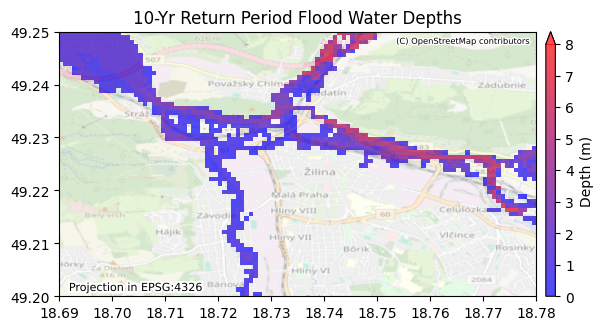

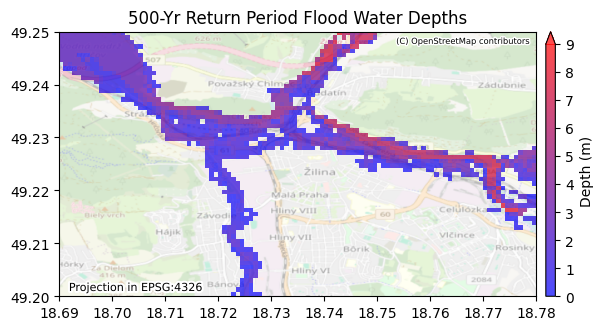

Population Raster Projection: EPSG:4326
Converted Coordinate Bounds:
  Longitudes: 18.69E --> 18.69 meters & 18.78E --> 18.78 meters
  Latitudes: 49.2N --> 49.2 meters & 49.25N --> 49.25 meters


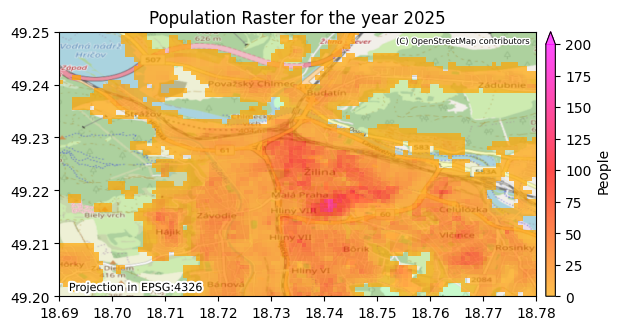

In [5]:
#Set shape box location
shpBBox = os.path.join(dirOSM, 'bbox.shp')

# Determine Raster EPSG Code (only works with osgeo)
ds = gdal.Open(rastDepths)
srs = osr.SpatialReference()
srs.ImportFromWkt(ds.GetProjection())
epsgRast = f'EPSG:{srs.GetAuthorityCode(None)}'
ds = None

print(f'Water Depth Raster Projection: {epsgRast}')

# Create a transformer for coordinate conversion
transformer = Transformer.from_crs('EPSG:4326', epsgRast, always_xy=True)

# Convert bounding box coordinates to raster CRS
xMin, yMin = transformer.transform(Longitude1, Latitude1)
xMax, yMax = transformer.transform(Longitude2, Latitude2)

# Ensure xMin < xMax and yMin < yMax
xMin, xMax = min(xMin, xMax), max(xMin, xMax)
yMin, yMax = min(yMin, yMax), max(yMin, yMax)

print('Converted Coordinate Bounds:')
print(f'  Longitudes: {Longitude1}E --> {xMin} meters & {Longitude2}E --> {xMax} meters')
print(f'  Latitudes: {Latitude1}N --> {yMin} meters & {Latitude2}N --> {yMax} meters')

# Define the bounding box coordinates based on the zoomed region
bboxRast = box(xMin, yMin, xMax, yMax)
bounding_box = gpd.GeoDataFrame(geometry=[bboxRast], crs=epsgRast)

# Write the GeoDataFrame to a shapefile
bounding_box.to_file(shpBBox)
print('Bounding Box Shapefile written to: '+shpBBox)

# Read GeoDataFrame from the bounding box shapefile
gdfBBox = gpd.read_file(shpBBox)
crsRast = gdfBBox.crs
bboxRast = gdfBBox.total_bounds

# Adjust bounding box coordinates for OSM data
bboxOSM = bboxRast
bboxOSM[1] = Latitude1
bboxOSM[3] = Latitude2
bboxOSM[0] = Longitude1
bboxOSM[2] = Longitude2

# Create a GeoSeries representing the bounding box polygon
bboxOSM_poly = gpd.GeoSeries(
    [Polygon([(bboxOSM[0], bboxOSM[1]), (bboxOSM[2], bboxOSM[1]),
              (bboxOSM[2], bboxOSM[3]), (bboxOSM[0], bboxOSM[3])])],
    crs=crsRast
)
bboxOSM_poly = bboxOSM_poly.to_crs(crsRast)

print(f'  {str(Latitude1)}N to {str(Latitude2)}N')
print(f'  {str(Longitude1)}E to {str(Longitude2)}E')
for RP in ImageReturnPeriod:
    rastDepths = os.path.join(dirDepths, f'Europe_RP{RP}_filled_depth.tif')
    # Read the raster using rasterio
    with rasterio.open(rastDepths) as src:
        window = from_bounds(xMin, yMin, xMax, yMax, src.transform)
        rDepths = src.read(1, window=window)
        rDepths = np.ma.masked_where((rDepths < -999) | (rDepths > 1000), rDepths)
        # Compute the maximum value from the masked data
        max_depth  = rDepths.max()
        
        # Find the closest multiple of 100 above the max_population value
        maxDepthLegend = ((max_depth // 1) + 1)
        missing_data_value = src.nodata
    # Check select bounding latitude-longitude box
    fig, ax = plt.subplots()
    im = ax.imshow(rDepths, vmin=0, vmax=maxDepthLegend, cmap=cmap_h2o, extent=(xMin, xMax, yMin, yMax),
                zorder=2, alpha=0.7)
    plt.title(f'{RP}-Yr Return Period Flood Water Depths')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    plt.colorbar(im, cax=cax,label='Depth (m)',extend='max')
    plt.text(.02,.02,f'Projection in {epsgRast}', fontsize=8,
             path_effects=[pe.withStroke(linewidth=3, foreground="white")], transform=ax.transAxes)
    ctx.add_basemap(ax=ax, crs=epsgRast, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size='6', alpha=0.5)
    txt = ax.texts[-1]
    txt.set_position([0.99,0.98])
    txt.set_ha('right')
    txt.set_va('top')
    plt.show()

##--------------------------------------------------------
## Population map

# Open the raster file
ds = gdal.Open(rastPopulation)
if ds is None:
    raise RuntimeError(f"Failed to open the raster file: {rastPopulation}")

# Get the projection from the raster file
proj_wkt = ds.GetProjection()
srs = osr.SpatialReference()
srs.ImportFromWkt(proj_wkt)

# Try to get the EPSG code
epsg_code = srs.GetAuthorityCode(None)

# Check if the EPSG code was successfully retrieved
if epsg_code is None:
    # If not, you might need to handle specific cases manually
    # Check if the projection matches known projections
    proj4_str = srs.ExportToProj4()
    if '+proj=moll' in proj4_str and '+datum=WGS84' in proj4_str:
        epsg_code = 'EPSG:54009'  # ESRI:54009 World Mollweide projection
    else:
        raise RuntimeError("Unable to determine EPSG code for the given projection.")
else:
    epsg_code = f"EPSG:{epsg_code}"

epsgRastPop = epsg_code
# Close the dataset
ds = None
print(f'Population Raster Projection: {epsgRastPop}')

# Create a transformer for coordinate conversion
if epsg_code == 'EPSG:54009':
    PopProj = '+proj=moll +datum=WGS84 +units=m' #MOLLWEIDE HAS TO BE MANUALLY INSERTED
else:
    PopProj = epsg_code

transformer = Transformer.from_crs('EPSG:4326', PopProj, always_xy=True)

# Convert bounding box coordinates to raster CRS
xMinPop, yMinPop = transformer.transform(Longitude1, Latitude1)
xMaxPop, yMaxPop = transformer.transform(Longitude2, Latitude2)

# Ensure xMin < xMax and yMin < yMax
xMinPop, xMaxPop = min(xMinPop, xMaxPop), max(xMinPop, xMaxPop)
yMinPop, yMaxPop = min(yMinPop, yMaxPop), max(yMinPop, yMaxPop)

print('Converted Coordinate Bounds:')
print(f'  Longitudes: {Longitude1}E --> {xMinPop} meters & {Longitude2}E --> {xMaxPop} meters')
print(f'  Latitudes: {Latitude1}N --> {yMinPop} meters & {Latitude2}N --> {yMaxPop} meters')

# Read the raster using rasterio
with rasterio.open(rastPopulation) as src:
    window = from_bounds(xMinPop, yMinPop, xMaxPop, yMaxPop, src.transform)
    rPopulation = src.read(1, window=window)
    rPopulation = np.ma.masked_where((rPopulation < 0.1), rPopulation)
    max_population = rPopulation.max()
    maxPopLegend = ((max_population // 100) + 1) * 100
    missing_data_value = src.nodata


fig, ax = plt.subplots()
im = ax.imshow(rPopulation, vmin=0, vmax=maxPopLegend, cmap=cmap_pop, extent=(xMinPop, xMaxPop, yMinPop, yMaxPop),
               zorder=2, alpha=0.7)
plt.title(f'Population Raster for the year {PopYear}')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
plt.colorbar(im, cax=cax,label='People',extend='max')
plt.text(.02,.02,f'Projection in {epsgRastPop}', fontsize=8,
             path_effects=[pe.withStroke(linewidth=3, foreground="white")], transform=ax.transAxes)
ctx.add_basemap(ax=ax, crs=epsgRastPop, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size='6', alpha=1)
txt = ax.texts[-1]
txt.set_position([0.99,0.98])
txt.set_ha('right')
txt.set_va('top')
plt.show()


## Conclusion

In the hazard assessment:
- The appropriate flood data was downloaded from online servers.
- The data was manipulated to have smaller files that only include the area of interest.
- The process was also outlined for population data, showcasing an example of adapting the process for a different data source. 

This code will also be present in the risk assessment, yet since the workflow will check if the data was already downloaded, running the hazard assessment first will not cause data to be downloaded twice. 